# Effects post-stratification

In [113]:
import numpy as np
import pandas as pd
from pathlib import Path
from datetime import datetime
from tqdm import tqdm
import pickle
from matplotlib import dates
import matplotlib.pyplot as plt
import seaborn as sns
import sys; sys.path.append('../')
from src.data_loader.data_loader import *

from sklearn.metrics import pairwise_distances
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from scipy.stats import spearmanr

import warnings
warnings.filterwarnings('ignore')
warnings.resetwarnings()
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
# Static data
counties, counties_date = load_counties()

In [3]:
deaths_df = get_cum_deaths_dataframe(n_days=28, onset_threshold=3, ma_width=7, time_series=True)
days = [d for d in deaths_df.columns if d[:4] == 'day_']

/Users/Ronan/miniconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)
../src/data_loader/data_loader.py:171: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  deaths_df.dropna(subset=['FIPS'], inplace=True)


In [20]:
ddf = deaths_df.copy()
ddf = ddf.merge(counties[counties.columns.difference(ddf.columns).to_list() + ['FIPS']], on='FIPS')

## Edits
ddf = ddf.rename({
    'Density per square mile of land area - Population': 'POP Density',
    'Density per square mile of land area - Housing units': 'Housing Density',
}, axis=1)

## Normalized Mobility
ddf['OD_at_onset_normalized'] = ddf['OD_at_onset'] / ddf['OD_baseline']
ddf['OD_2wk_before_onset_normalized'] = ddf['OD_2wk_before_onset'] / ddf['OD_baseline']
ddf['OD_2wk_after_onset_normalized'] = ddf['OD_2wk_after_onset'] / ddf['OD_baseline']

## Black, african, hispanic, native american population
ddf['BAHN'] = ddf[['H_FEMALE', 'H_MALE', 'BA_FEMALE', 'BA_MALE', 'IA_MALE', 'IA_FEMALE']].sum(axis=1)

pop_vars = [
    'day_28',
    'Beds',
    'HospCt',
    'Total_age65plus',
    'POVALL_2018',
    'BAHN',
]
ddf[[l + '_normalized' for l in pop_vars]] = ddf[pop_vars].div(ddf['POP_ESTIMATE_2018'], axis=0)

## Normalize others
log_vars = [
    'day_28_normalized',
    'day_28',
    'OD_at_onset',
    'OD_baseline',
    'POP_ESTIMATE_2018',
    'POP Density',
    'Housing Density',
]
## Compensate for 0 being a possible value
ddf[[l + ' (log)' for l in log_vars]] = ddf[log_vars].transform('log')


##
UPPER_CUTOFF = np.inf
LOWER_CUTOFF = 4

ddf = ddf[ddf[days[-1]] >= LOWER_CUTOFF]
ddf = ddf[ddf[days[-1]] <= UPPER_CUTOFF]

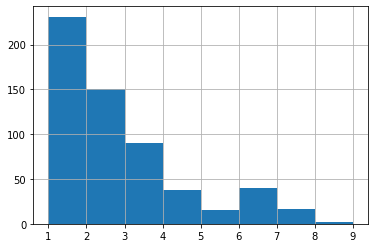

In [63]:
ddf['Rural-urban_Continuum Code_2013'].hist(bins=[1,2,3,4,5,6,7,8,9])

## RUCC 3

In [143]:
RUCC = 3
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

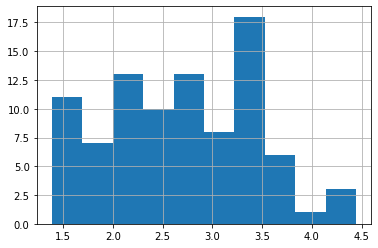

In [144]:
strat_df['day_28'].transform('log').hist()

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


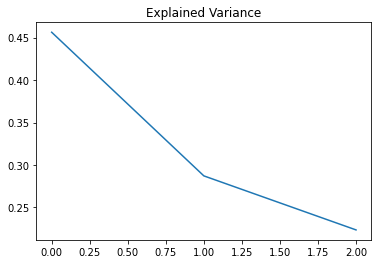

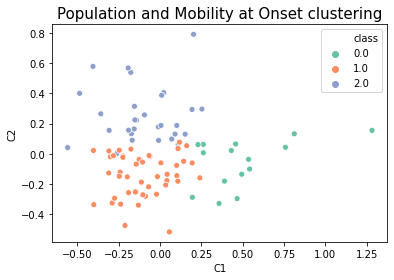

In [147]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=3, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=3, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

f,ax=plt.subplots()
g = sns.scatterplot(
    x='C1',
    y='C2',
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','C3','class']),
    hue='class',
    palette="Set2",
    ax=ax
)

plt.title(f'Population and Mobility at Onset clustering', y=1, fontsize=15)
plt.show()

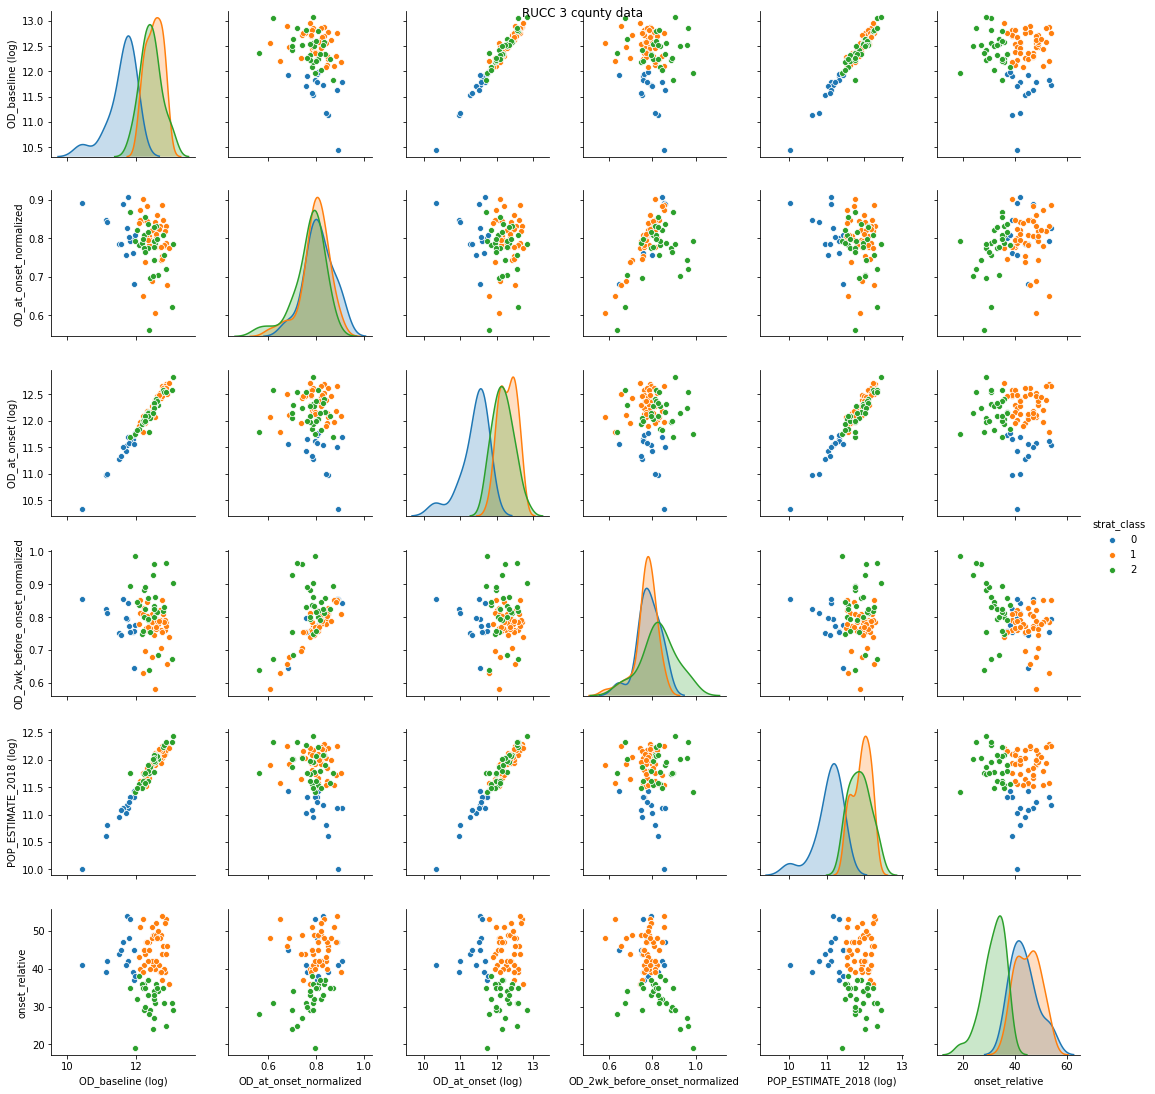

In [148]:
hue = 'strat_class'
g = sns.pairplot(strat_df, vars=vars, hue=hue)
g.fig.suptitle(f'RUCC {RUCC} county data', y=1)
plt.show()

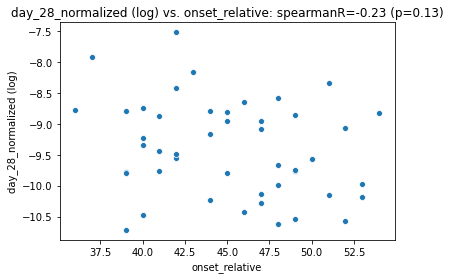

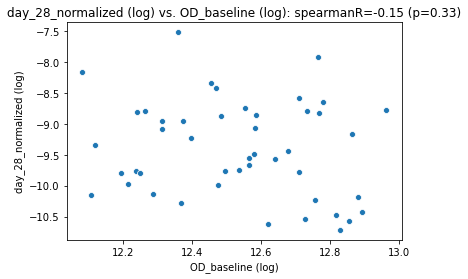

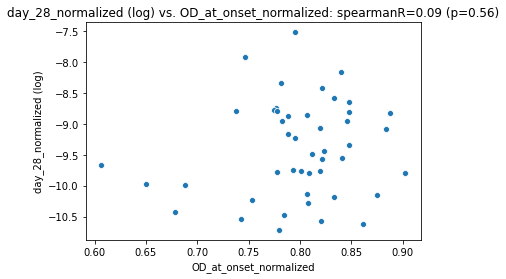

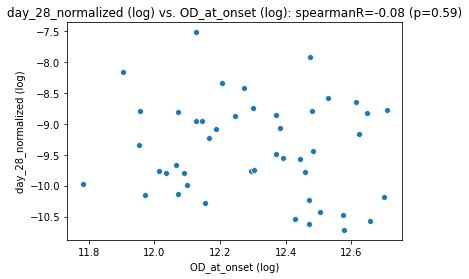

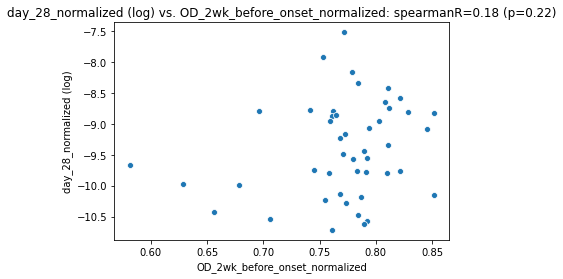

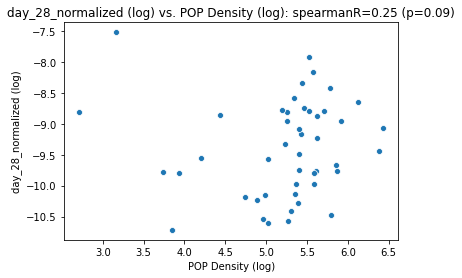

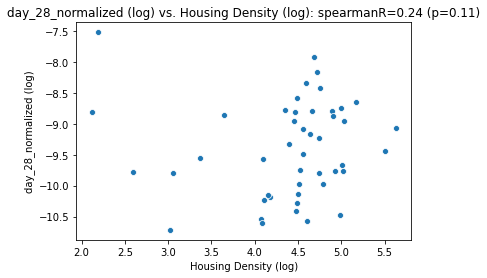

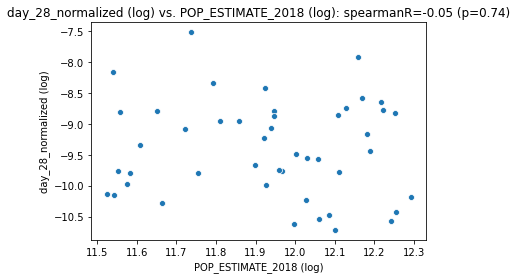

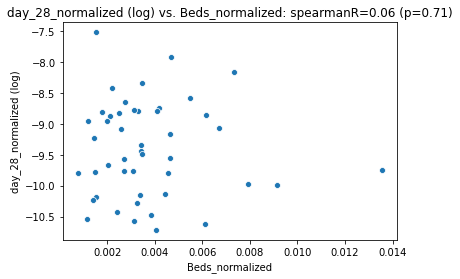

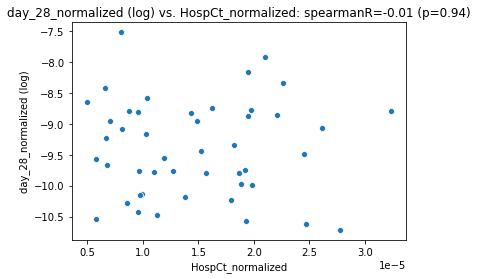

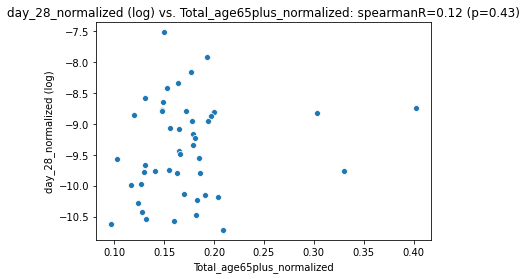

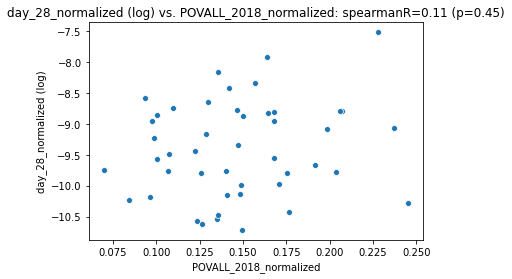

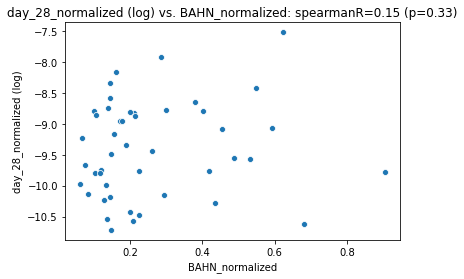

In [149]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 1
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

## RUCC 2

In [150]:
RUCC = 2
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


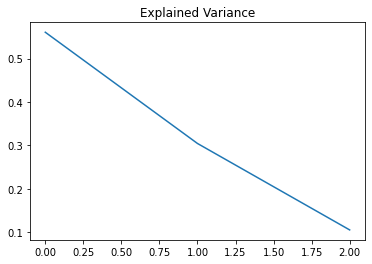

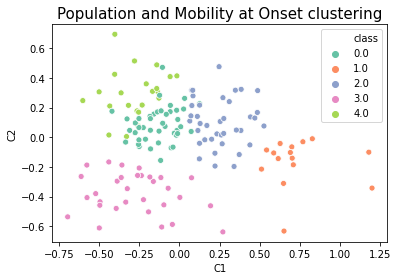

In [153]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=3, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=5, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

f,ax=plt.subplots()
g = sns.scatterplot(
    x='C1',
    y='C2',
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','C3','class']),
    hue='class',
    palette="Set2",
    ax=ax
)

plt.title(f'Population and Mobility at Onset clustering', y=1, fontsize=15)
plt.show()

### Confounder independent cluster

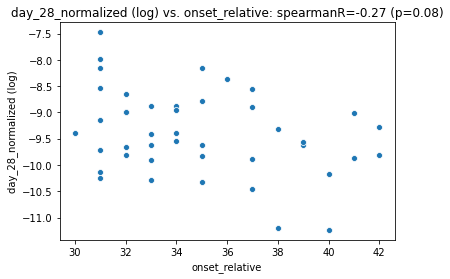

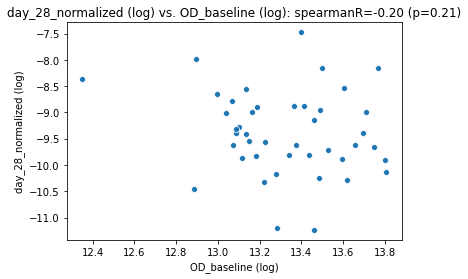

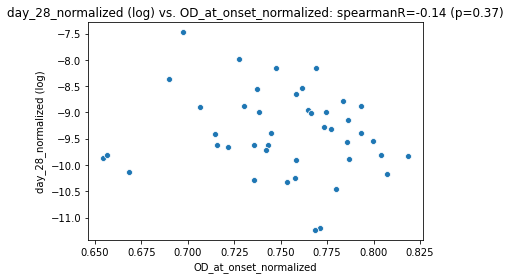

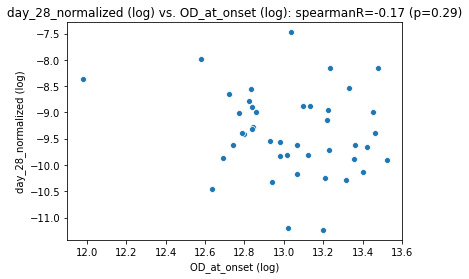

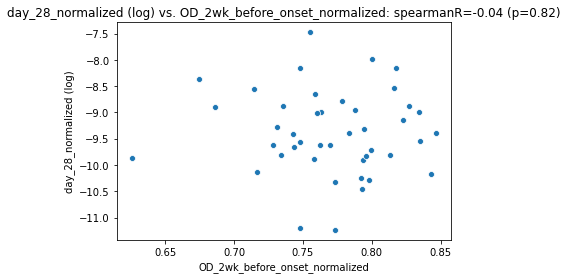

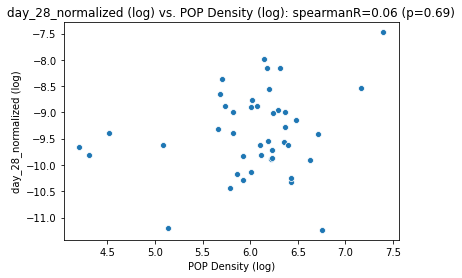

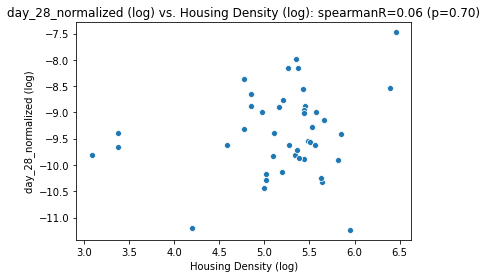

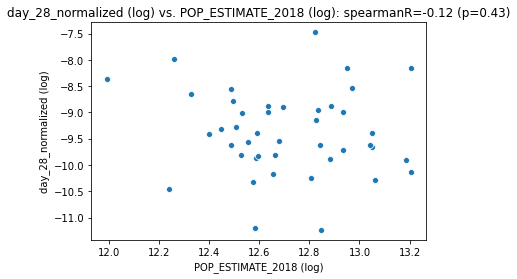

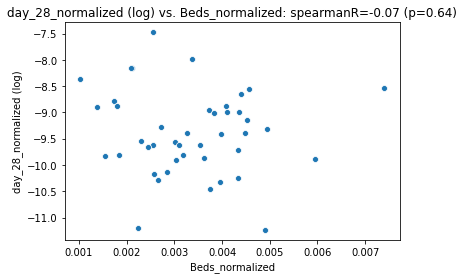

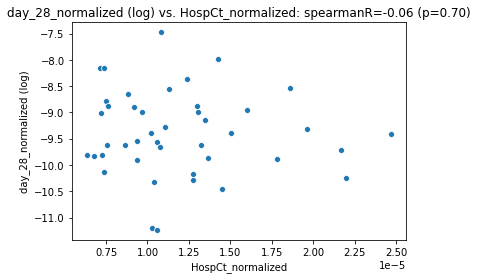

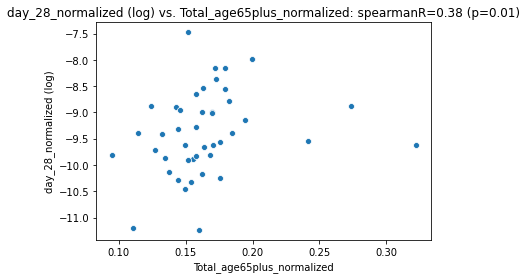

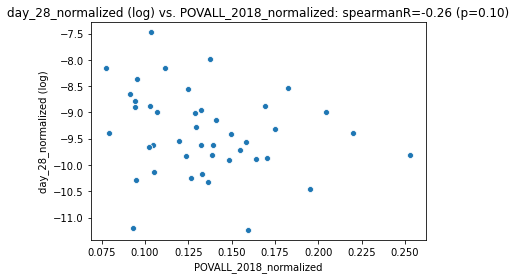

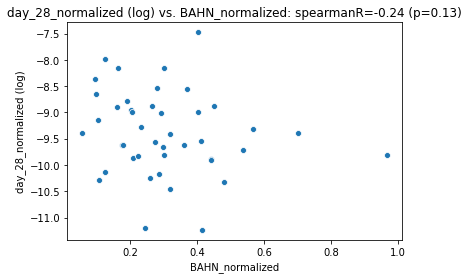

In [154]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 0
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

### Confounder dependent clusters

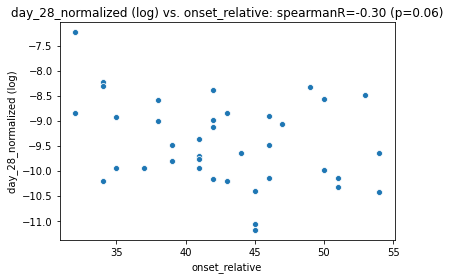

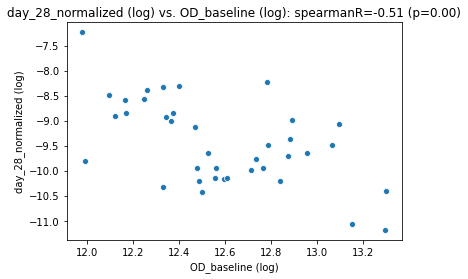

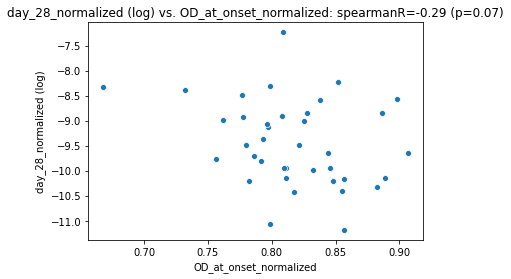

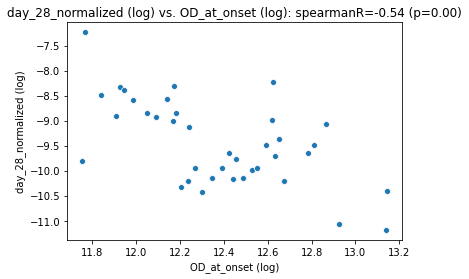

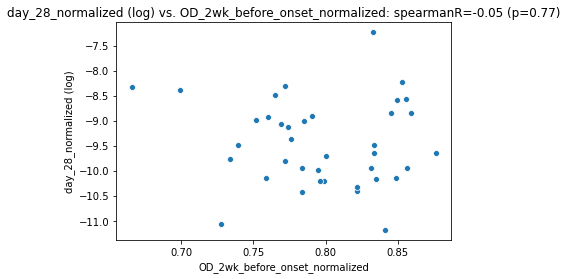

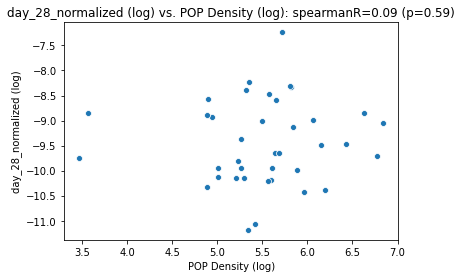

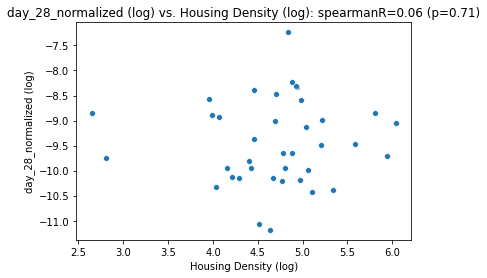

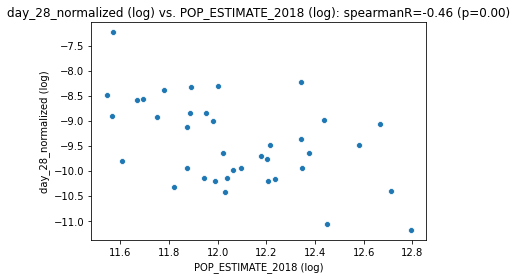

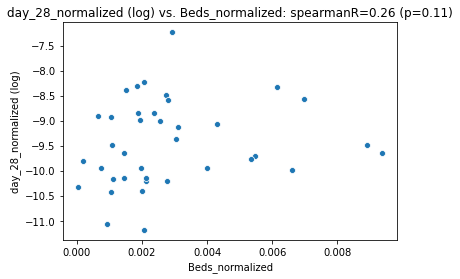

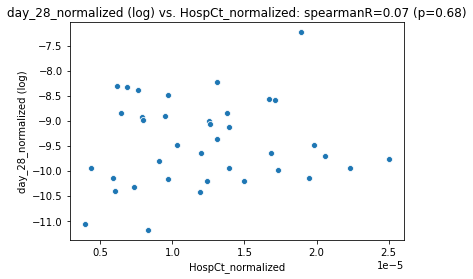

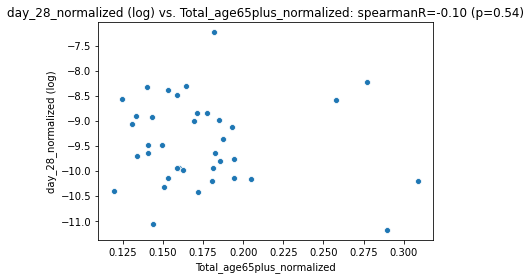

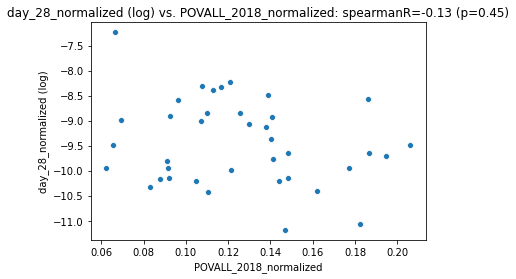

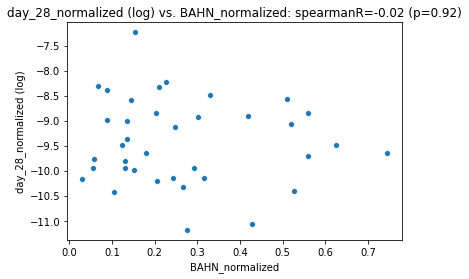

In [155]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 2
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

## RUCC 1

In [157]:
RUCC = 1
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


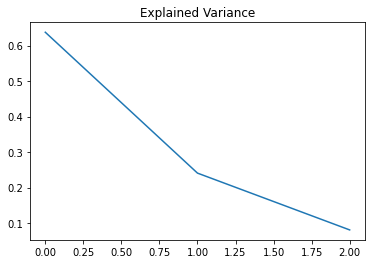

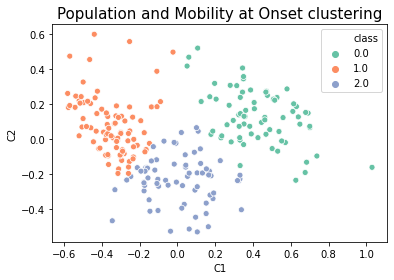

In [165]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=3, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=3, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

f,ax=plt.subplots()
g = sns.scatterplot(
    x='C1',
    y='C2',
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','C3','class']),
    hue='class',
    palette="Set2",
    ax=ax
)

plt.title(f'Population and Mobility at Onset clustering', y=1, fontsize=15)
plt.show()

### Confounder independent cluster
Age relevant, Hospitals noticeable negative correlation

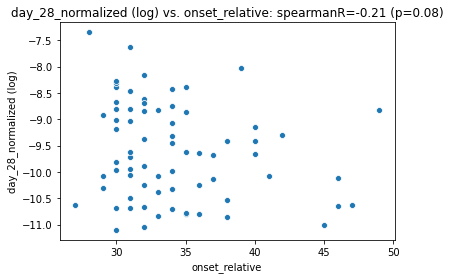

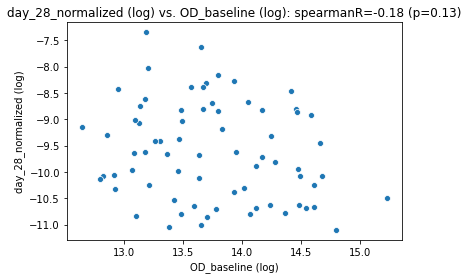

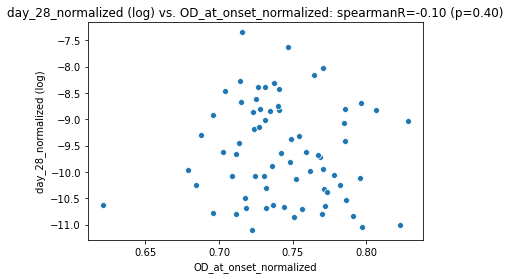

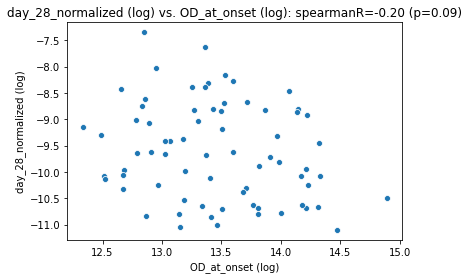

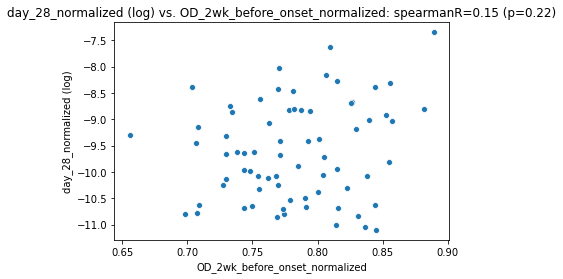

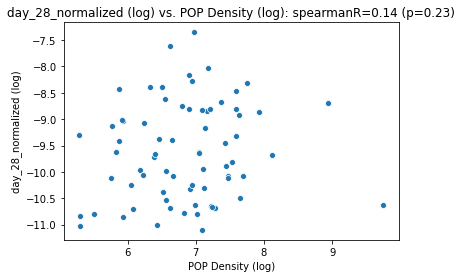

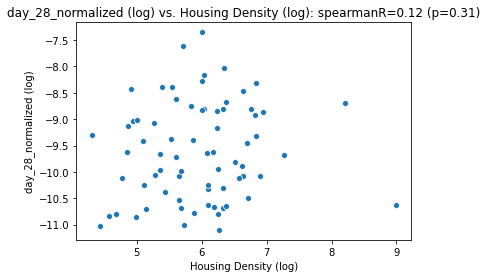

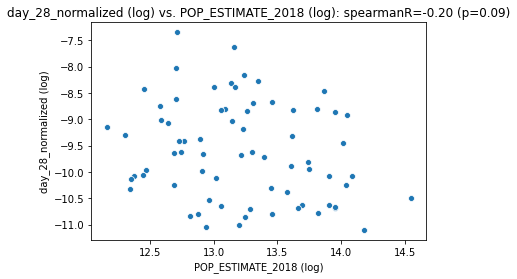

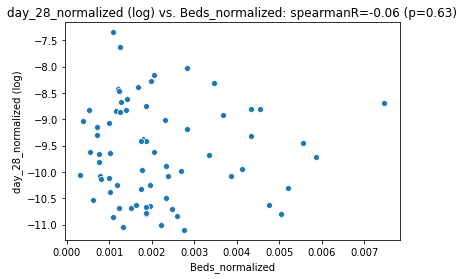

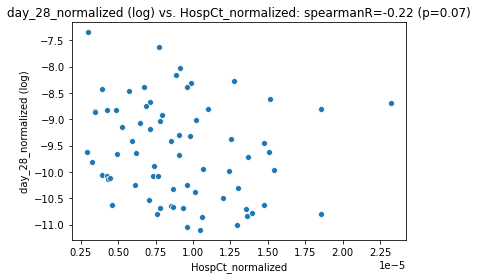

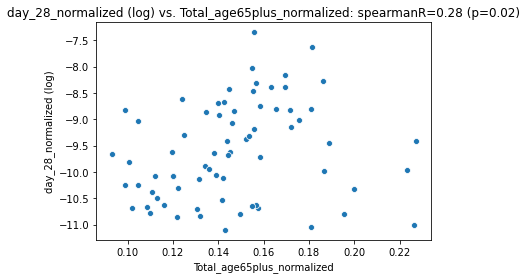

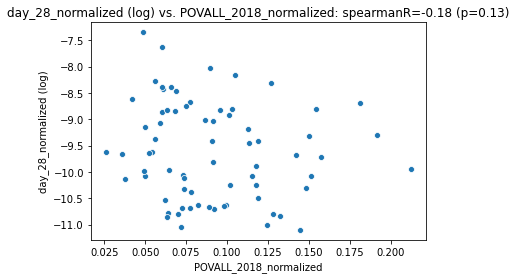

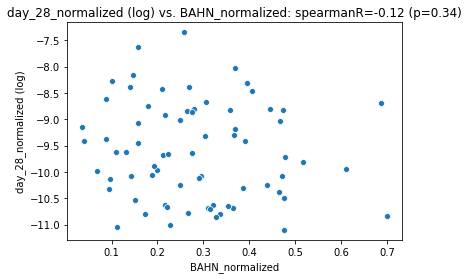

In [166]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 2
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

### Confounder dependent cluster
Hospitals significant positive correlation

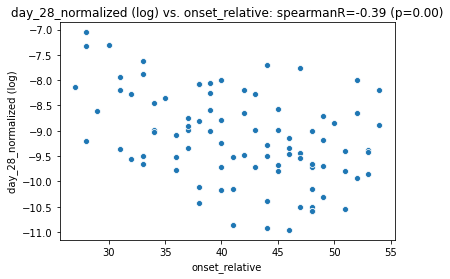

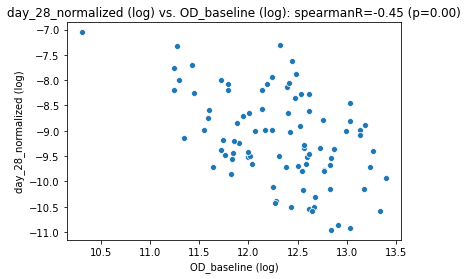

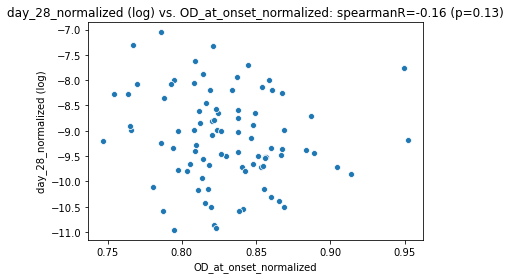

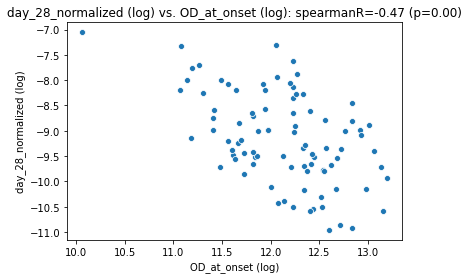

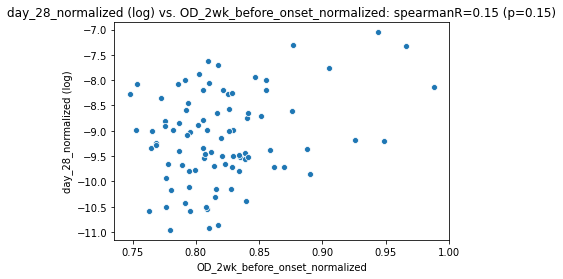

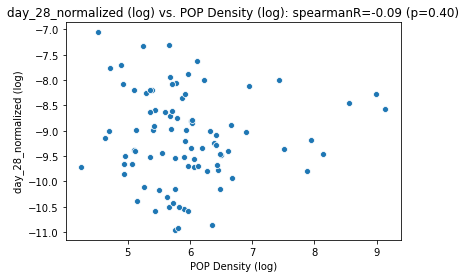

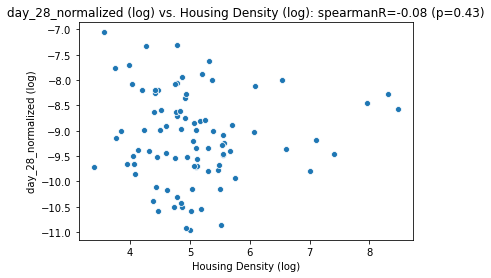

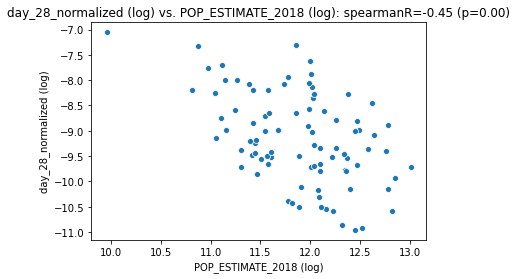

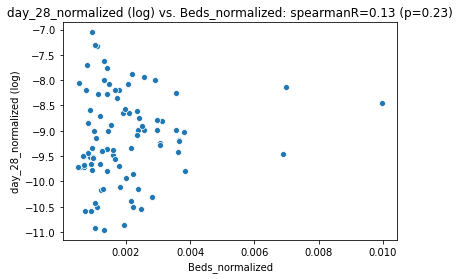

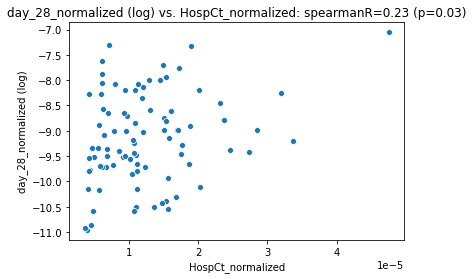

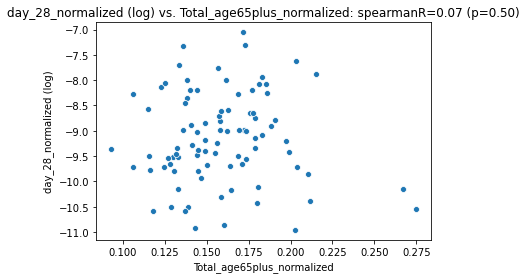

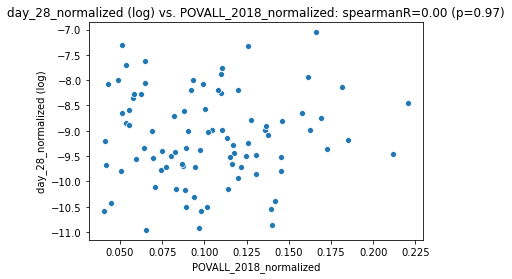

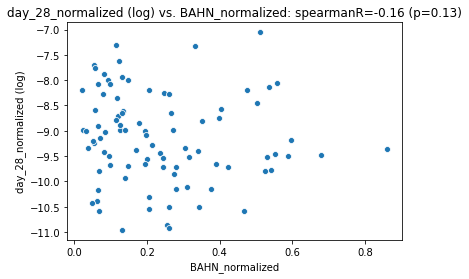

In [168]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 1
data = strat_df[strat_df['strat_class'] == strat_class]
y = 'day_28_normalized (log)'
for x in predictor_vars:
    fig,ax = plt.subplots()
    ax = sns.scatterplot(
        x=x,
        y=y,
        data=data,
        ax=ax
    )
    r,p = spearmanr(
        data[x],
        data[y]
    )
    ax.set_title(f'{y} vs. {x}: spearmanR={r:.2f} (p={p:.2f})')

## Regress RUCC
Rather than just analyzing the correlation, here a log-link linear model is fit to the parameters of interest and the coefficients are analyzed. Small p-values indicate significant variables. Done on RUCC 2

In [212]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import TweedieRegressor, LinearRegression, Lasso, ElasticNet
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import statsmodels.api as sm

In [170]:
RUCC = 2
strat_df = ddf[ddf['Rural-urban_Continuum Code_2013'] == RUCC]

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


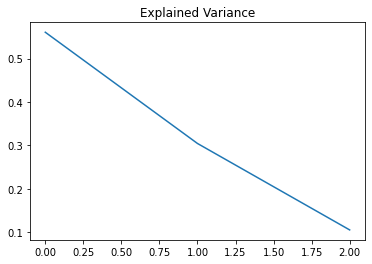

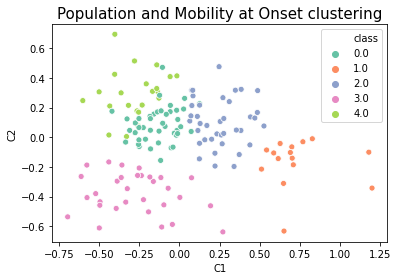

In [171]:
#vars = ['POP_ESTIMATE_2018 (log)', 'OD_baseline (log)']
vars = [
    'OD_baseline (log)',
    'OD_at_onset_normalized',
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',
    'POP_ESTIMATE_2018 (log)',
    'onset_relative',
]
X = strat_df[vars].values.copy()
XX = X - X.min(axis=0)[None,:]
XX /= XX.max(axis=0)[None,:]
pca = PCA(n_components=3, svd_solver='full')
XXX = pca.fit_transform(XX)

clustering = KMeans(n_clusters=5, random_state=0).fit(XXX)
#clustering = AgglomerativeClustering(n_clusters=6, linkage='average', affinity='euclidean').fit(XX)
strat_df['strat_class'] = clustering.labels_

plt.plot(np.arange(XXX.shape[1]), pca.explained_variance_ratio_); plt.title('Explained Variance')

f,ax=plt.subplots()
g = sns.scatterplot(
    x='C1',
    y='C2',
    data=pd.DataFrame(data=np.hstack((XXX, clustering.labels_[:,None])),columns=['C1','C2','C3','class']),
    hue='class',
    palette="Set2",
    ax=ax
)

plt.title(f'Population and Mobility at Onset clustering', y=1, fontsize=15)
plt.show()

In [172]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 0
target_var = 'day_28_normalized'

X = strat_df[strat_df['strat_class'] == strat_class][predictor_vars].copy()
y = strat_df[strat_df['strat_class'] == strat_class][target_var].copy()

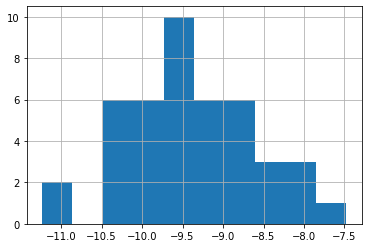

In [174]:
strat_df[strat_df['strat_class'] == strat_class]['day_28_normalized'].transform('log').hist()

### Fitted on Confounder Independent Cluster
Strong fit, many significant components

In [224]:
scaler = MinMaxScaler()
XX = scaler.fit_transform(X)

glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log))
glm = glm.fit()

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


In [225]:
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      day_28_normalized   No. Observations:                   43
Model:                            GLM   Df Residuals:                       29
Model Family:                Gaussian   Df Model:                           13
Link Function:                    log   Scale:                      2.8035e-09
Method:                          IRLS   Log-Likelihood:                 369.37
Date:                Fri, 19 Jun 2020   Deviance:                   8.1302e-08
Time:                        23:40:08   Pearson chi2:                 8.13e-08
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.3602      4.753      0.917      0.3

In [264]:
r2_score(y, glm_results.predict(sm.add_constant(XX)))

0.8208610427543787

In [263]:
pd.DataFrame(np.vstack((glm.pvalues[1:][None,:],glm.params[1:][None,:])), columns=predictor_vars).rename(index={0:'pvalues', 1:'coef'})

,onset_relative,OD_baseline (log),OD_at_onset_normalized,OD_at_onset (log),OD_2wk_before_onset_normalized,POP Density (log),Housing Density (log),POP_ESTIMATE_2018 (log),Beds_normalized,HospCt_normalized,Total_age65plus_normalized,POVALL_2018_normalized,BAHN_normalized
pvalues,0.037146,0.006817,0.006314,0.006564,0.180389,0.000001,0.000004,0.318465,0.389897,0.044762,0.000015,0.828363,0.161067
coef,-1.364337,-390.637233,-58.994045,413.882462,-1.146834,29.948074,-28.916309,-1.506822,0.631367,-0.991185,5.360240,-0.163011,0.975838


### Fitted on Confounder Independent Cluster
Poor fit, few significant parameters

In [265]:
predictor_vars = [
    'onset_relative',# s
    'OD_baseline (log)',# s,
    'OD_at_onset_normalized',# s,
    'OD_at_onset (log)',
    'OD_2wk_before_onset_normalized',# s,
    'POP Density (log)',# s,
    'Housing Density (log)',# s,
    'POP_ESTIMATE_2018 (log)',# s,
    'Beds_normalized',# s,
    'HospCt_normalized',# s,
    'Total_age65plus_normalized',# s,
    'POVALL_2018_normalized',# s
    'BAHN_normalized',# s
]
strat_class = 2
target_var = 'day_28_normalized'

X = strat_df[strat_df['strat_class'] == strat_class][predictor_vars].copy()
y = strat_df[strat_df['strat_class'] == strat_class][target_var].copy()

In [266]:
scaler = MinMaxScaler()
XX = scaler.fit_transform(X)

glm = sm.GLM(y, sm.add_constant(XX), family=sm.families.Gaussian(sm.families.links.log))
glm = glm.fit()

/Users/Ronan/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  after removing the cwd from sys.path.


In [267]:
print(glm.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:      day_28_normalized   No. Observations:                   38
Model:                            GLM   Df Residuals:                       24
Model Family:                Gaussian   Df Model:                           13
Link Function:                    log   Scale:                      5.5234e-09
Method:                          IRLS   Log-Likelihood:                 314.35
Date:                Sat, 20 Jun 2020   Deviance:                   1.3256e-07
Time:                        00:01:53   Pearson chi2:                 1.33e-07
No. Iterations:                    92                                         
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        -18.0426      9.600     -1.879      0.0

In [268]:
r2_score(y, glm_results.predict(sm.add_constant(XX)))

-0.8855890089642995

In [269]:
pd.DataFrame(np.vstack((glm.pvalues[1:][None,:],glm.params[1:][None,:])), columns=predictor_vars).rename(index={0:'pvalues', 1:'coef'})

,onset_relative,OD_baseline (log),OD_at_onset_normalized,OD_at_onset (log),OD_2wk_before_onset_normalized,POP Density (log),Housing Density (log),POP_ESTIMATE_2018 (log),Beds_normalized,HospCt_normalized,Total_age65plus_normalized,POVALL_2018_normalized,BAHN_normalized
pvalues,0.005612,0.270739,0.259855,0.254376,0.439881,0.588917,0.547738,0.909693,0.456911,0.403328,0.800294,0.050485,0.122845
coef,-2.139499,80.583972,19.283307,-86.605737,-1.520376,-5.091291,5.652618,0.275358,0.970979,0.737746,-0.336510,-2.109398,1.632323
